## Dual Doppler lobe plotter

DD lobe plotter. Needs py-ART Grid file since DD lobes are calculated in radar relative coordinates.

Based on code created by Scott Collis, Johnathan Helmus, Zachary Sherman, and myself

In [2]:
import pyart
import gzip
from matplotlib import pyplot as plt
from matplotlib import rcParams
from scipy import ndimage
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import tempfile
import glob
import re
from copy import deepcopy
from IPython.display import Image, display
import math
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


In [3]:
# Input the range of dates and time wanted for the collection of images
start_year = 2005
start_day = 9
start_month = 12
start_hour = 21
start_minute = 1
start_second = 0

end_year = 2005
end_month = 12
end_day = 9
end_hour = 23
end_minute = 50
end_second = 0

data_path = '/home/rjackson/multidop_grids/'

This looks for all of the available timeperiods in the data_path directory and pulls out
the file names that match the given time periods above.

In [4]:
# get_radar_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_dda_times(start_year, start_month, start_day,
                  start_hour, start_minute, end_year,
                  end_month, end_day, end_hour, 
                  end_minute, minute_interval=5):

    start_time = datetime(start_year,
                      start_month,
                      start_day,
                      start_hour,
                      start_minute,
                      )
    end_time = datetime(end_year,
                      end_month,
                      end_day,
                      end_hour,
                      end_minute,
                      )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path +
                      'cf_compliant_grid' +
                      year_str +
                      month_str +
                      day_str +
                      '*.nc')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-15:-3]
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[8:10]
        minute_str = date_str[10:12]
        second_str = '00'
             
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            0)
        time_list.append(cur_time)
        
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
   
    for times in time_list_sorted:         
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
                           
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_grid_from_dda(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path +
                    'cf_compliant_grid' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str + '.nc')
    
    radar = pyart.io.read_grid(file_name_str)
    return radar

In [5]:
# Plot the radars from given time.

times = get_dda_times(start_year, start_month, start_day,
                      start_hour, start_minute, end_year,
                      end_month, end_day, end_hour, 
                      end_minute, minute_interval=0)

We are about to load grid files for 1 days
Looking for files with format /home/rjackson/multidop_grids/cf_compliant_grid20051209*.nc


In [6]:
def get_bca(grid):
    berr_origin = [-12960.1,-23091.1]
    x,y = np.meshgrid(grid.x['data'], grid.y['data'])
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-berr_origin[0],2)+pow(y-berr_origin[1],2))
    c = np.sqrt(berr_origin[0]*berr_origin[0]+berr_origin[1]*berr_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-berr_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

## Grid plotting code

This code creates plots from all of the Grids developed by multidop

This loads the Grid files and creates the animation

In [18]:
# Reflectivity plot callback functions
def plot_dd_lobe(frame_number):

    plt.clf()   
    pyart_grid = get_grid_from_dda(times[frame_number])    
    level = 6    
    CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
    CPOLGridDisplay.plot_basemap(min_lat=-12.8, max_lat=-12.0,
                                 min_lon=130.4, max_lon=131.6,
                                 auto_range=False,
                                 lat_lines=[-12.8, -12.6, -12.4, -12.2, -12.0],
                                 lon_lines=[130.4, 130.6, 130.8, 131.0, 131.2, 131.4, 131.6],
                                 resolution='h')
    CPOLGridDisplay.basemap.drawmapscale(131.2, -12.1, 130.6, -12.6, 20)
    CPOLGridDisplay.basemap.fillcontinents()
    lons, lats = pyart_grid.get_point_longitude_latitude(level=level)
     
    # Plot every second arrow
    lons = lons[0::2,0::2]
    lats = lats[0::2,0::2]
    bca = get_bca(pyart_grid)
    bca = bca[0::2, 0::2]
    CSa = CPOLGridDisplay.basemap.contour(lons, lats,
                                          bca, latlon='True',
                                          levels=[math.pi/6, 5*math.pi/6],
                                          linewidths=2)
    
    cpol_latitude = -12.249166
    cpol_longitude = 131.04445
    berr_latitude = -12.456944
    berr_longitude = 130.925
    berr_x, berr_y = CPOLGridDisplay.basemap(berr_longitude, berr_latitude)
    plt.annotate('Berrima', xy=(berr_x, berr_y), 
                 xycoords='data', fontweight='bold',
                 fontsize=20)
    cpol_x, cpol_y = CPOLGridDisplay.basemap(cpol_longitude, cpol_latitude)
    plt.annotate('CPOL', xy=(cpol_x, cpol_y), 
                 xycoords='data', fontweight='bold',
                 fontsize=20)

# Plot DD lobe

/home/rjackson/anaconda3/envs/pyart/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide
/home/rjackson/anaconda3/envs/pyart/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/envs/pyart/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


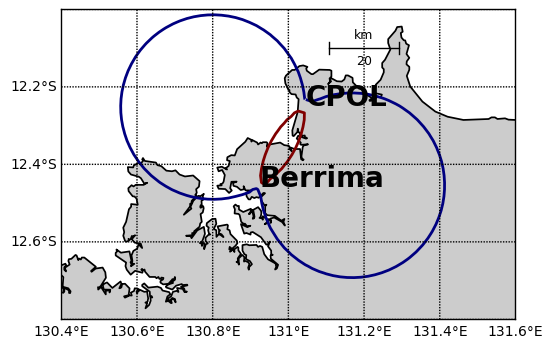

In [19]:
plt.subplot(211)
plot_dd_lobe(0)